##Flight Delay Prediction Using Machine Learning ✈️
**Objective:**

The goal of this project is to build a predictive model that determines whether a flight will be delayed by more than 15 minutes based on flight-related features.

##Dataset Overview

We have two datasets:

**`flight_delays_train.csv`** – Training dataset containing labeled flight delay data.

**`flight_delays_test.csv`** – Test dataset for making predictions.

Features:

Time-based: `Month`, `DayofMonth`, `DayOfWeek`, `DepTime`

Flight-related: `UniqueCarrier`, `Origin`, `Dest`, `Distance`

Target Variable: `dep_delayed_15min` (1 = Delayed, 0 = Not Delayed)

In [ ]:
##Loading required libraries
# Data Handling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
import optuna  # Advanced hyperparameter tuning

# Model Saving & Deployment
import joblib
import pickle

# API Development (if needed for deployment)
from flask import Flask, request, jsonify
from fastapi import FastAPI

# Miscellaneous
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [ ]:
# Load datasets
train_path = "flight_delays_train.csv"
test_path = "flight_delays_test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Check the first few rows of the dataset
print("Training Data Sample:")
print(df_train.head())

print("\nTest Data Sample:")
print(df_test.head())

Training Data Sample:
  Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y  

Test Data Sample:
  Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0   c-7       c-25       c-3      615            YV    MRY  PHX       598
1   c-4       c-17       c-2      739            WN    LAS  HOU      1235
2  c-12        c-2       c-7      651            MQ    GSP  ORD       577
3   c-3       c-25       c-7     1614            WN    BWI  MHT     

##Convert Target Variable to Binary
* Converts the target column dep_delayed_15min from categorical ('Y', 'N') into numerical values (1 = Delayed, 0 = Not Delayed). This is necessary because machine learning models require numerical inputs.
* Uses LabelEncoder to convert categorical columns (UniqueCarrier, Origin, Dest) into numeric values.
* Each unique category is mapped to a unique integer.
* Removes the "c-" prefix from Month, DayofMonth, and DayOfWeek.
* Converts the values back to integers for numerical processing.

In [ ]:
# Convert target variable into binary (0 = Not Delayed, 1 = Delayed)
df_train['dep_delayed_15min'] = df_train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

# Encode categorical features (Label Encoding for UniqueCarrier, Origin, Dest)
label_encoders = {}
categorical_cols = ['UniqueCarrier', 'Origin', 'Dest']

for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le

In [ ]:
# Function to clean 'c-' prefix from Month, DayofMonth, and DayOfWeek
def clean_column_values(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.replace("c-", "", regex=True).astype(int)

clean_column_values(df_train, ["Month", "DayofMonth", "DayOfWeek"])
clean_column_values(df_test, ["Month", "DayofMonth", "DayOfWeek"])

print(df_train.head())
print(df_test.head())

   Month  DayofMonth  DayOfWeek  DepTime  UniqueCarrier  Origin  Dest  \
0      8          21          7     1934              0      18    78   
1      4          20          3     1548             18     217   171   
2      9           2          5     1422             20     228    59   
3     11          25          6     1015             15      78   175   
4     10           7          6     1828             19     174   199   

   Distance  dep_delayed_15min  
0       732                  0  
1       834                  0  
2       416                  0  
3       872                  0  
4       423                  1  
   Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance
0      7          25          3      615            YV    MRY  PHX       598
1      4          17          2      739            WN    LAS  HOU      1235
2     12           2          7      651            MQ    GSP  ORD       577
3      3          25          7     1614            WN 

Clean and standardize the `DepTime` **(Departure Time) column** to ensure consistency and accuracy in time-based feature extraction.

* Ensures `DepTime` has **4 digits** by adding leading zeros if necessary (e.g., `945` → `0945`).
* Corrects invalid "24xx" times by converting them to `00xx` (e.g., `2405` → `0005` to maintain a valid 24-hour format).
* **Removes erroneous times (`25xx` or higher)** to ensure no unrealistic values remain.
* Formats `DepTime` as a readable time (hh:mm) by inserting a colon (e.g., `0930` → `09:30`).
* Converts `DepTime` into a proper **24-hour time format** using `pd.to_datetime()`.

In [ ]:
# Function to format DepTime into four-digit hhmm format
def format_deptime(df):
    #add zeros at the beginning to have 4 digits
    df['DepTime'] = df['DepTime'].astype(str).str.zfill(4)
    #if the first two digits are 24, convert to zeros
    df['DepTime'] = df['DepTime'].apply(lambda x: '00' + x[2:] if x[:2] == '24' else x)
    #if the hour is 2500 or more, delte the row
    df = df[df['DepTime'].str[:2] != '25']
    #add : between the first two digits and the last 2
    df['DepTime'] = df['DepTime'].str[:2] + ':' + df['DepTime'].str[2:]
    #convert the data type into 24 hour data type
    df['DepTime'] = pd.to_datetime(df['DepTime'], format='%H:%M').dt.strftime('%H:%M')

format_deptime(df_train)
format_deptime(df_test)

print(df_train.head())
print(df_test.head())

   Month  DayofMonth  DayOfWeek DepTime  UniqueCarrier  Origin  Dest  \
0      8          21          7    1934              0      18    78   
1      4          20          3    1548             18     217   171   
2      9           2          5    1422             20     228    59   
3     11          25          6    1015             15      78   175   
4     10           7          6    1828             19     174   199   

   Distance  dep_delayed_15min  
0       732                  0  
1       834                  0  
2       416                  0  
3       872                  0  
4       423                  1  
   Month  DayofMonth  DayOfWeek DepTime UniqueCarrier Origin Dest  Distance
0      7          25          3    0615            YV    MRY  PHX       598
1      4          17          2    0739            WN    LAS  HOU      1235
2     12           2          7    0651            MQ    GSP  ORD       577
3      3          25          7    1614            WN    BWI  MHT

## Creating logistic regression model

In [ ]:
# Define features and target
X = df_train.drop('dep_delayed_15min', axis=1)
y = df_train['dep_delayed_15min']

#let's use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#let's do the logistical regression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
#show the results of the regression
model.score(X_train, y_train)

0.8078375

##LRM results

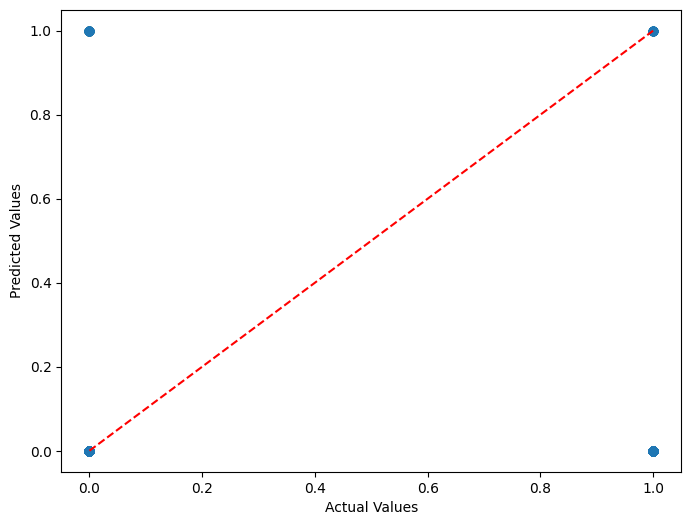

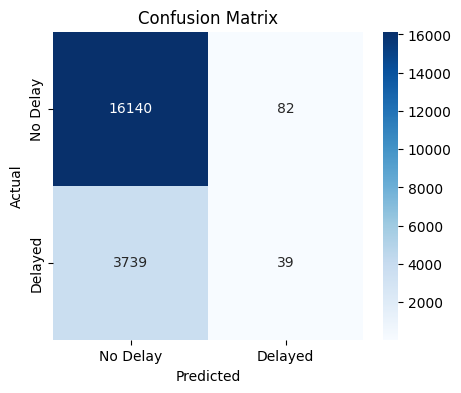

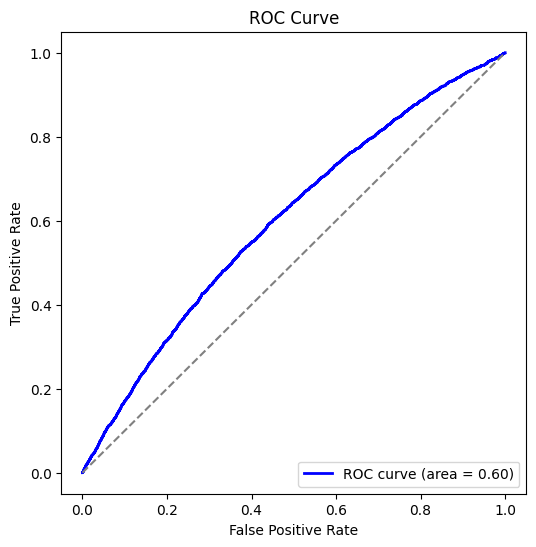

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
# Get model predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores for ROC curve

# 1. Plot Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Delay", "Delayed"], yticklabels=["No Delay", "Delayed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


##MLP Classifier
trains, evaluates, and visualizes the performance of an MLP (Multi-Layer Perceptron) classifier to predict flight delays.

* Initializes and trains an **MLP model** with two hidden layers (`100` and `50` neurons) and a maximum of `500` iterations.
* Fits the model using the training data (`X_train`, `y_train`) to learn patterns from historical flight delay data.
* Makes predictions on the test data (`X_test`), providing both binary classifications (`mlp_pred`) and probability scores (`mlp_pred_proba`).
* Evaluates the model using **accuracy** and a **classification report** to measure performance.
* Generates a confusion matrix to visualize correct and incorrect predictions.
* Plots the ROC curve to analyze the tradeoff between true positive and false positive rates.


Uses neural networks (MLP) to find complex relationships between flight features and delays.

Evaluates how well the model distinguishes delayed vs. non-delayed flights.
Provides visual insights (confusion matrix and ROC curve) to assess model reliability.

This step helps determine if MLP performs better than other models (e.g., logistic regression, random forest, or XGBoost) and guides further optimization.

MLP Accuracy: 0.8124
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     16222
           1       0.77      0.01      0.02      3778

    accuracy                           0.81     20000
   macro avg       0.79      0.50      0.46     20000
weighted avg       0.80      0.81      0.73     20000



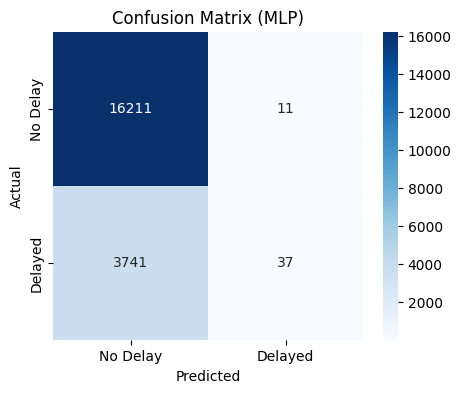

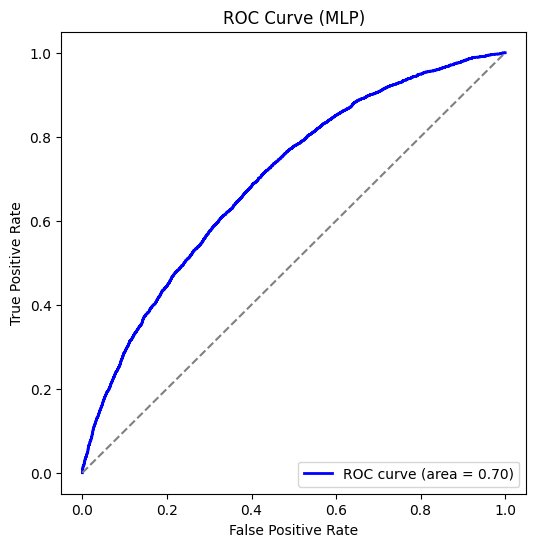

In [ ]:

from sklearn.neural_network import MLPClassifier

# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42) # Example parameters, adjust as needed
mlp.fit(X_train, y_train)

# Make predictions
mlp_pred = mlp.predict(X_test)
mlp_pred_proba = mlp.predict_proba(X_test)[:, 1]

# Evaluate the MLP model
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

# Plot the confusion matrix for the MLP model
cm_mlp = confusion_matrix(y_test, mlp_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=["No Delay", "Delayed"], yticklabels=["No Delay", "Delayed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MLP)")
plt.show()

# Plot the ROC Curve for the MLP model
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_pred_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(6, 6))
plt.plot(fpr_mlp, tpr_mlp, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_mlp:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MLP)")
plt.legend(loc="lower right")
plt.show()